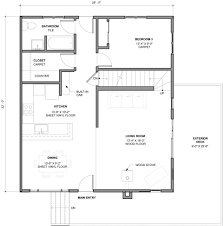

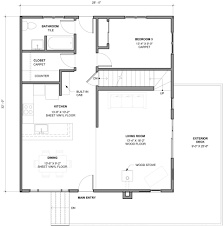

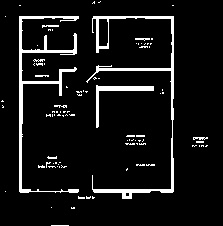

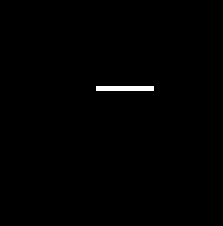

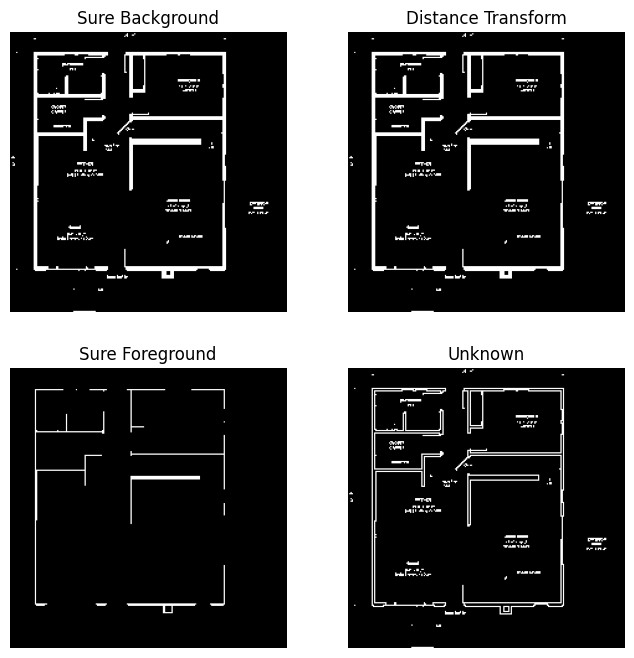

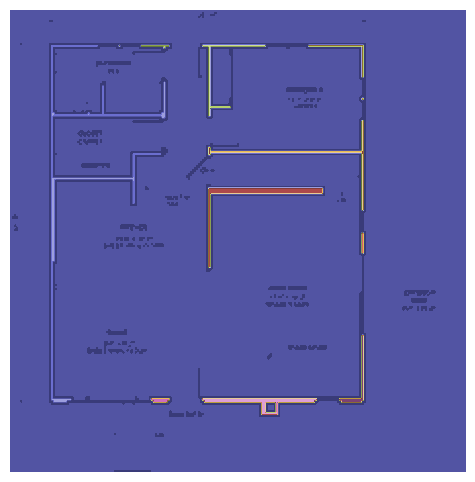

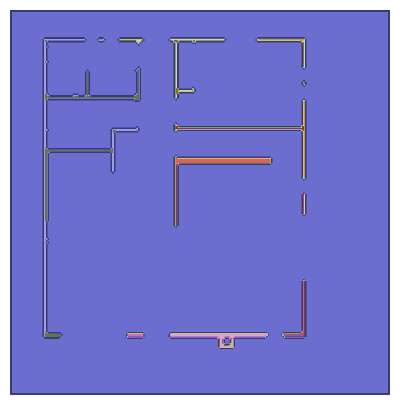

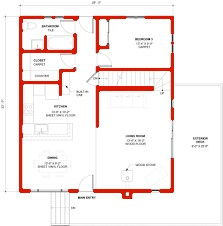

In [ ]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

# Function to display images
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

# Image loading
img = cv2.imread("images.jpg")
imshow(img)

# Grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

# Threshold processing
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)

# Noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img2 = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
imshow(bin_img2)

# Create subplots for visualization
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# Sure background area
sure_bg = bin_img
imshow(sure_bg, axes[0, 0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0, 1])
axes[0, 1].set_title('Distance Transform')

# Sure foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1, 0])
axes[1, 0].set_title('Sure Foreground')

# Unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1, 1])
axes[1, 1].set_title('Unknown')

plt.show()

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 255] = 0

# Visualize markers
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

# Apply watershed algorithm
markers = cv2.watershed(img, markers)

# Visualize watershed result
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

# Extract unique labels
labels = np.unique(markers)

# Extract and draw contours
coins = []
for label in labels[2:]:
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(contours[0])

# Draw the contours on the image
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


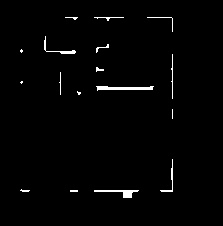

In [2]:
import cv2
import numpy as np
from IPython.display import Image, display

# Function to display images
def imshow(img):
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

# Image loading
img = cv2.imread("images.jpg")

# Grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Noise reduction
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection
edges = cv2.Canny(blur, 50, 150)

# Adaptive thresholding
bin_img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)

# Combine edges with binary image to strengthen edges
bin_img = cv2.bitwise_or(bin_img, edges)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Sure foreground area
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that the sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)

# Create the result image
img[markers == -1] = [0, 0, 255]
mask = np.zeros_like(gray)
mask[markers > 1] = 255

# Refine the mask using morphological operations
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Display the final segmented mask
imshow(mask)


1000 synthetic floorplan images and masks generated.
